## Multilabel Classification

In [49]:
from robingrad import Tensor, draw_dot
import robingrad.nn as nn
from robingrad.optim import SGD
from robingrad.state import get_parameters
from sklearn import datasets
import pandas as pd
import numpy as np
import edamame.eda as eda
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

### Dataset

In [50]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print(X.shape)
print(type(X))
print(y.shape)
print(type(y))
num_classes = len(np.unique(y))
print(num_classes)

(150, 4)
<class 'numpy.ndarray'>
(150,)
<class 'numpy.ndarray'>
3


In [51]:
X = pd.DataFrame(X, columns=iris.feature_names)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [52]:
y = pd.Series(y)
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [53]:
X_train, y_train, X_test, y_test = eda.setup(X,y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112, 4)
(38, 4)
(112,)
(38,)


In [54]:
X_train_s = eda.scaling(X_train)
X_test_s = eda.scaling(X_test)
y_train = y_train.squeeze().to_numpy()
y_test = y_test.squeeze().to_numpy()
print(X_train_s.shape)
print(X_test_s.shape)
print(y_train.shape)
print(y_test.shape)

(112, 4)
(38, 4)
(112,)
(38,)


In [55]:
y_train_ohe = np.eye(num_classes)[y_train]
y_train_ohe[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [56]:
X_train_t = Tensor(X_train_s, requires_grad=True)
print(type(X_train_t), X_train_t.shape)
y_train_ohe_t = Tensor(y_train_ohe, requires_grad=True).reshape((112,3))
print(type(y_train_ohe_t), y_train_ohe_t.shape)

<class 'robingrad.tensor.Tensor'> (112, 4)
<class 'robingrad.tensor.Tensor'> (112, 3)


In [57]:
class RobinNet:
    def __init__(self):
        self.l1 = nn.Linear(4,16)
        self.l2 = nn.Linear(16,16)
        self.l3 = nn.Linear(16,3)
    def __call__(self, x):
        x = self.l1(x)
        x = x.relu()
        x = self.l2(x)
        x = x.relu()
        x = self.l3(x)
        return x

In [58]:
model = RobinNet()
res = model(X_train_t[0].reshape((1,4)))
# draw_dot(res)

In [59]:
params = get_parameters(model)
opt = SGD(params)

In [ ]:
def cross_entropy_loss(forward_array, y_true): # y_true == y_train_ohe[i]
    exp_forward = [elem.exp() for _, elem in enumerate(forward_array)]
    norm_term = Value(0.)
    for _, elem in enumerate(exp_forward):
        norm_term = norm_term + elem
    softmax_vec = [elem / norm_term for _, elem in enumerate(exp_forward)]
    bce_losses = []
    for j in range(len(softmax_vec)):
        output = softmax_vec[j]
        target = Value(y_true[j])
        neg_output = Value(1.) - softmax_vec[j]
        bce_loss = -(target * output.log() + (Value(1)-target)*neg_output.log())
        bce_losses.append(bce_loss)
    BCEloss = Value(0.)
    for _, single_loss in enumerate(bce_losses):
        BCEloss = BCEloss + single_loss
    BCEloss.backward()
    y_predicted = [elem.data for _, elem in enumerate(softmax_vec)]
    return BCEloss, y_predicted.index(max(y_predicted))

In [ ]:
epochs = 200
for epoch in range(epochs):
    y_pred = []
    losses = []
    s = time.monotonic()
    for i in range(X_train_t.shape[0]):
        output = model(X_train_t[i].reshape((1,4)))

In [61]:
output = model(X_train_t[0].reshape((1,4)))
target = y_train_ohe_t[0].reshape((1,3))

def cross_entropy_loss(forward_array, y_true):
    exp_forward = forward_array.exp()
    norm_term = exp_forward.sum()
    softmax_vec = exp_forward/norm_term

In [87]:
out = Tensor([2,3,4], requires_grad=True).reshape((1,3))
print("= out =")
print(out)
print(out.shape)
print("\n")
exp_forward = out.exp()
print("= exp_forward =")
print(exp_forward)
print(exp_forward.shape)
print("\n")
norm_term = exp_forward.sum()
print("= norm_term =")
print(norm_term)
print(norm_term.shape)
print("\n")
softmax_vec = exp_forward/norm_term
print("= softmax_vec =")
print(softmax_vec)
print(softmax_vec.shape)
print("\n")
target = y_train_ohe_t[2].reshape((1,3)) # just for having one on the 3rd position
print("= target =")
print(target)
print(target.shape)
print("\n")
neg_output = Tensor.ones_like(softmax_vec, requires_grad=True) - softmax_vec
print("= neg_output =")
print(neg_output)
print(neg_output.shape)
print("\n")
bce_losses = -(target * out.log() + (Tensor.ones_like(softmax_vec, requires_grad=True)-target)*neg_output.log())
print("= bce_losses =")
print(bce_losses)
print(bce_losses.shape)
print("\n")
BCELoss = bce_losses.sum()
print("= BCELoss =")
print(BCELoss)
print(BCELoss.shape)
print("\n")

= out =
Tensor: reshape
data: 
[[2. 3. 4.]]
grad: 
[[0. 0. 0.]]
dtype: float32
(1, 3)


= exp_forward =
Tensor: exp
data: 
[[ 7.3890557 20.085537  54.59815  ]]
grad: 
[[0. 0. 0.]]
dtype: float32
(1, 3)


= norm_term =
Tensor: sum
data: 
82.07273864746094
grad: 
0.0
dtype: float32
()


= softmax_vec =
Tensor: __mul__
data: 
[[0.09003057 0.24472848 0.66524094]]
grad: 
[[0. 0. 0.]]
dtype: float32
(1, 3)


= target =
Tensor: reshape
data: 
[[0. 0. 1.]]
grad: 
[[0. 0. 0.]]
dtype: float32
(1, 3)


= neg_output =
Tensor: __add__
data: 
[[0.90996945 0.75527155 0.33475906]]
grad: 
[[0. 0. 0.]]
dtype: float32
(1, 3)


= bce_losses =
Tensor: __mul__
data: 
[[ 0.09434425  0.28067797 -1.3862944 ]]
grad: 
[[0. 0. 0.]]
dtype: float32
(1, 3)


= BCELoss =
Tensor: sum
data: 
-1.0112721920013428
grad: 
0.0
dtype: float32
()




In [98]:
a = Tensor([0,0,0], requires_grad=True)
b = Tensor.ones((1,3), requires_grad=True)
c = b + a
print(c)
print(c.shape)
d = c.sum()
d.backward()

Tensor: __add__
data: 
[[1. 1. 1.]]
grad: 
[[0. 0. 0.]]
dtype: float32
(1, 3)


In [100]:
a = Tensor.ones((1,1))
b = Tensor.zeros((1,))
print(a)
print(b)
c = Tensor.broadcast(a, b)
print(c)

Tensor: ones
data: 
[[1.]]
dtype: float32
Tensor: zeros
data: 
[0.]
dtype: float32


ValueError: setting an array element with a sequence.

In [101]:
a = Tensor(0)
a

Tensor: tensor
data: 
0.0
dtype: float32

In [103]:
isinstance(a, Tensor)

True

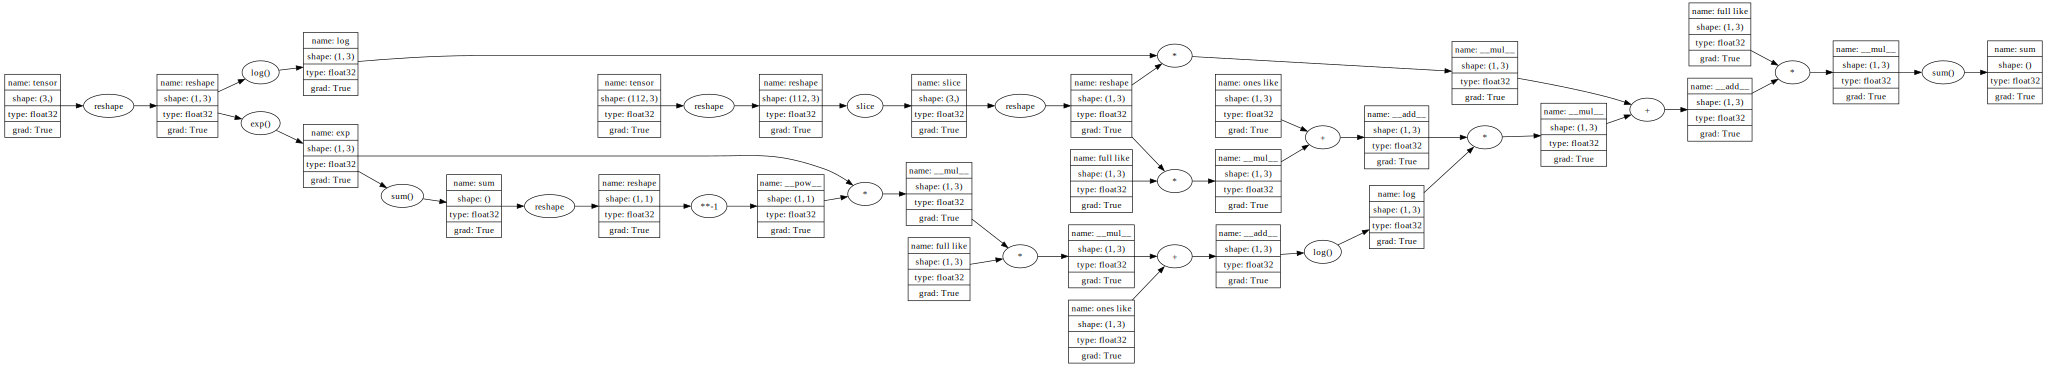

In [70]:
draw_dot(BCELoss, inspect=False)

In [71]:
BCELoss.backward()

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,3)